# 0. Instalacion de utilitarios Pyspark

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.3.4/spark-2.3.4-bin-hadoop2.7.tgz
!tar xf spark-2.3.4-bin-hadoop2.7.tgz

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
!tar xf spark-2.4.4-bin-hadoop2.7.tgz


In [0]:
!pip install -q findspark

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"


In [0]:
!pip install pyspark

In [0]:
from pyspark.sql import SparkSession
from pyspark import SparkContext
spark = SparkSession.builder.master("local").getOrCreate()
sc = SparkContext.getOrCreate()

In [0]:
ls

# 1. Lectura del origen datos

In [0]:
# Lectura desde un archivo fisico
from google.colab import files
uploaded = files.upload()

In [0]:

# Conexion al drive
#---------------------------
from google.colab import drive
drive.mount('/content/drive')

In [0]:
ls

#2.  Cargando los datos en formato Spark

In [0]:
DS_spam = spark.read.csv('/content/drive/My Drive/PySpark Machine Learning en plataforma Big Data/Training R ML en Casos de Negocios/9_Analisis_texto_Spam_emaling/Identificando_correos_spam_vf.csv', sep=';', header=True, inferSchema=True)

# 2.1 Revision de formatos 
DS_spam.printSchema()

In [11]:
# Dimensiona de base
print((DS_spam.count(),len(DS_spam.columns)))

(5574, 2)


In [12]:
# 2.2 Revisiones  
DS_spam.show(5, truncate = False)

+-----+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|clase|texto                                                                                                                                                                                                              |
+-----+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|0    |Ir hasta el punto de jurong, loco .. Disponible s�lo en bugis n gran mundo La buf� e ... Cine no consigui� Amore wat ...                                                                                           |
|0    |lar bien ... Bromas WIF u oni ...                                                                                

In [13]:
# 2.3 Validacion de carga del total de registros
print(DS_spam.count())

5574


In [14]:
# 2.4 Exploracion inicial
DS_spam.describe().show()

+-------+--------------------+--------------------+
|summary|               clase|               texto|
+-------+--------------------+--------------------+
|  count|                5574|                5572|
|   mean| 0.13406317300789664|               645.0|
| stddev|  0.3407507548977697|                 NaN|
|    min|                   0|! Sus semanales t...|
|    max|jam�n S�, ll�mame...|����Qu�???? Hola ...|
+-------+--------------------+--------------------+



In [15]:
# 2.5 Los casos de Spam
DS_spam.groupBy('clase').count().show(10,False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|clase                                                                                                                                                                      |count|
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|0                                                                                                                                                                          |4825 |
|jam�n S�, ll�mame si tienes un minuto                                                                                                                                      |1    |
|1                                                                                                  

In [0]:
#2.6 Filtrando los casos a analizar 
DS_spam_2=DS_spam.filter(DS_spam["Clase"]>=0)

In [17]:
# 2.7 Validacion
DS_spam_2.groupBy('clase').count().show(10,False)

+-----+-----+
|clase|count|
+-----+-----+
|0    |4825 |
|1    |747  |
+-----+-----+



In [18]:
# Revision de los valores
DS_spam_2.show(5, truncate = False)

+-----+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|clase|texto                                                                                                                                                                                                              |
+-----+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|0    |Ir hasta el punto de jurong, loco .. Disponible s�lo en bugis n gran mundo La buf� e ... Cine no consigui� Amore wat ...                                                                                           |
|0    |lar bien ... Bromas WIF u oni ...                                                                                

In [19]:
#Creando la columna distancia
from pyspark.sql.functions import length,rand 
DS_spam_2=DS_spam_2.withColumn('length',length(DS_spam['texto'])) 
DS_spam_2.orderBy(rand()).show(10,False)

+-----+---------------------------------------------------------------------------------------------------------------------------------------------------------------+------+
|clase|texto                                                                                                                                                          |length|
+-----+---------------------------------------------------------------------------------------------------------------------------------------------------------------+------+
|0    |Aight que he sido puesto en libertad, si piensa que podr�a texto me Blake de direcci�n? Se me ocurre que no estoy muy seguro de lo que estoy haciendo lo que yo|159   |
|0    |Te deseo un hermoso d�a. Cada momento que revela a�n m�s cosas para mantenerlo sonriendo. Do disfrutar de ella.                                                |111   |
|0    |Ocupado aqu�. Tratando de terminar para el a�o nuevo. Estoy deseando que finalmente satisfacer ...                    

In [20]:
# Cantidad de texto
DS_spam_2.groupBy('clase').agg({'Length':'mean'}).show()

+-----+-----------------+
|clase|      avg(Length)|
+-----+-----------------+
|    0|81.73181347150259|
|    1|163.7550200803213|
+-----+-----------------+



In [22]:
# Revision preliminar de los comentarios
from pyspark.sql.functions import rand
DS_spam_2.orderBy(rand()).show(10,False)

+-----+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------+
|clase|texto                                                                                                                                                                                                                                                   |length|
+-----+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------+
|0    |Lol ... Oh, no nena, no voy a estar cayendo en su lugar despu�s de la medianoche, pero gracias por la invitaci�n                                                                                         

# 2.  Realizando la codificación de los emaling

In [0]:
from pyspark.ml.feature import Tokenizer
from pyspark.ml.feature import StopWordsRemover
tokenization=Tokenizer(inputCol='texto',outputCol='tokens')
tokenized_df=tokenization.transform(DS_spam_2)
stopword_removal=StopWordsRemover(inputCol='tokens', outputCol='refined_tokens')
refined_text_df=stopword_removal.transform(tokenized_df)

In [24]:
refined_text_df.orderBy(rand()).show(10,False)

+-----+-------------------------------------------------------------------------------------------------------------------------+------+-----------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------+
|clase|texto                                                                                                                    |length|tokens                                                                                                                                               |refined_tokens                                                                                                                                       |
+-----+-----------------------------------------------------------------------------------------------------------------------

In [25]:
# Conteo de las palabras

from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import *
len_udf = udf(lambda s: len(s), IntegerType())
refined_text_df = refined_text_df.withColumn("token_count",
len_udf(col('refined_tokens')))
refined_text_df.orderBy(rand()).show(10)

+-----+--------------------+------+--------------------+--------------------+-----------+
|clase|               texto|length|              tokens|      refined_tokens|token_count|
+-----+--------------------+------+--------------------+--------------------+-----------+
|    0|Viendo la televis...|    50|[viendo, la, tele...|[viendo, la, tele...|          8|
|    0|�Est� siendo buen...|    28|[�est�, siendo, b...|[�est�, siendo, b...|          5|
|    1|Su pr�ximo incre�...|   192|[su, pr�ximo, inc...|[su, pr�ximo, inc...|         31|
|    0|�Se cose su pantal�n|    20|[�se, cose, su, p...|[�se, cose, su, p...|          4|
|    1|T dice 2 09066358...|   156|[t, dice, 2, 0906...|[dice, 2, 0906635...|         24|
|    0|Yar lo contrario ...|    60|[yar, lo, contrar...|[yar, lo, contrar...|         11|
|    0|Lo siento, llamar...|    28|[lo, siento,, lla...|[lo, siento,, lla...|          5|
|    0|Saludos para CALL...|   110|[saludos, para, c...|[saludos, para, c...|         14|
|    0|Mmm

# 4.  Preparando la información para el modelamiento

In [26]:
# Creando las variables nevesarias para el modelamiento
from pyspark.ml.feature import CountVectorizer

count_vec=CountVectorizer(inputCol='refined_tokens',outputCol='features')
cv_text_df=count_vec.fit(refined_text_df).transform(refined_text_df)
cv_text_df.select(['refined_tokens','token_count','features','Clase']).show(10)

+--------------------+-----------+--------------------+-----+
|      refined_tokens|token_count|            features|Clase|
+--------------------+-----------+--------------------+-----+
|[ir, hasta, el, p...|         24|(14644,[0,2,3,4,6...|    0|
|[lar, bien, ..., ...|          8|(14644,[6,10,61,3...|    0|
|[entrada, libre, ...|         40|(14644,[0,2,3,4,5...|    1|
|[dun, decir, hor,...|         11|(14644,[6,65,68,1...|    0|
|[nah, creo, que, ...|         10|(14644,[1,13,178,...|    0|
|[freemsg, hola, q...|         33|(14644,[0,1,5,7,9...|    1|
|[incluso, mi, her...|         12|(14644,[0,8,16,41...|    0|
|[seg�n, su, petic...|         30|(14644,[0,9,12,14...|    0|
|[��ganador!!, com...|         29|(14644,[0,1,8,9,2...|    1|
|[tenido, sus, tel...|         29|(14644,[0,2,3,4,1...|    1|
+--------------------+-----------+--------------------+-----+
only showing top 10 rows



In [0]:
# Variables propias para el modelamiento

model_text_df=cv_text_df.select(['features','token_count','Clase'])

In [28]:
# Consolidadno toda la información codificada del mensaje en los correos

from pyspark.ml.feature import VectorAssembler
df_assembler = VectorAssembler(inputCols=['features','token_count'],outputCol='features_vec')
model_text_df = df_assembler.transform(model_text_df)
model_text_df.printSchema()

root
 |-- features: vector (nullable = true)
 |-- token_count: integer (nullable = true)
 |-- Clase: string (nullable = true)
 |-- features_vec: vector (nullable = true)



In [0]:
# Adecuando el formato de la variable Clase a numerica
from pyspark.sql.types import IntegerType
model_text_df = model_text_df.withColumn("Clase", model_text_df["Clase"].cast(IntegerType()))

In [30]:
model_text_df.printSchema()

root
 |-- features: vector (nullable = true)
 |-- token_count: integer (nullable = true)
 |-- Clase: integer (nullable = true)
 |-- features_vec: vector (nullable = true)



# 5.  Seleccionando la muestra de aprendizaje y validacion


In [0]:
training_df,test_df=model_text_df.randomSplit([0.75,0.25],seed=1234)

In [32]:
training_df.groupBy('Clase').count().show()

+-----+-----+
|Clase|count|
+-----+-----+
|    1|  579|
|    0| 3627|
+-----+-----+



In [33]:
test_df.groupBy('Clase').count().show()

+-----+-----+
|Clase|count|
+-----+-----+
|    1|  168|
|    0| 1198|
+-----+-----+



# 6.  Modelamiento de predictivo de texto

In [0]:
from pyspark.ml.classification import LogisticRegression

log_reg=LogisticRegression(featuresCol='features_vec',labelCol='Clase').fit(training_df)

In [0]:
results=log_reg.evaluate(test_df).predictions

In [38]:
results.show(10,truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------+-----+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------+-------------------------------------------+----------+
|features                                                                  

# 7. Evaluacion del modelo


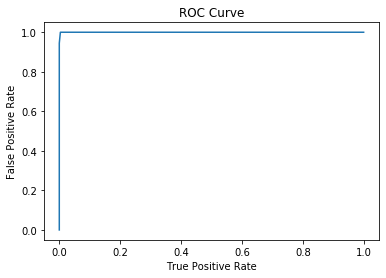

Training set areaUnderROC: 0.9999009539373905


In [39]:
import matplotlib.pyplot as plt
import numpy as np

trainingSummary = log_reg.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))